In [1]:
import matplotlib.pyplot as plt
import numpy as np

from analytic import asian_option_value
from monte_carlo import MonteCarloStock, AsianMonteCarloStock, MonteCarloStockManager, obtain_mean_and_stds_control_variate
from simulation_manager import SimulationManager

In [2]:
# Run cell to increase font sizes. Usefull when saving plots
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (8,6)

## Part 1

STD at 1000 is 4.800636473337231                             


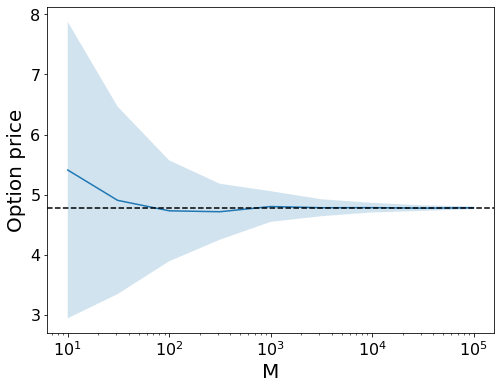

In [4]:
# Convergence study

Ms = np.logspace(1, 5, 9, dtype=int)

n_instances = 100
mean_values, std_values = [], []
for M in Ms:

    manager = SimulationManager(MonteCarloStockManager, n_instances,  M=M)

    mean, std = manager.calc_attribute(lambda man: man.calc_option_price()[1], run=False)

    mean_values.append(mean)
    std_values.append(std)

mean_values = np.array(mean_values)
std_values = np.array(std_values)

binomial_tree_value = 4.779

print(f"STD at {Ms[4]} is {mean_values[4]}")
plt.plot(Ms, mean_values)
plt.fill_between(Ms, mean_values - std_values, mean_values + std_values, alpha=0.2)
plt.axhline(binomial_tree_value, c="k", ls="--")

plt.xlabel("M")
plt.ylabel("Option price")
plt.xscale("log")
plt.show() 

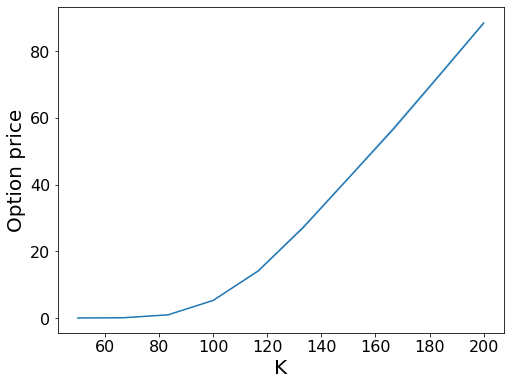

In [5]:
# Strike price study
M = 10**3
n_instances = 10
mean_values, std_values = [], []

Ks = np.linspace(50, 200, 10)

for K in Ks:

    manager = SimulationManager(MonteCarloStockManager, n_instances, M=M, K=K)

    mean, std = manager.calc_attribute(lambda man: man.calc_option_price()[1], run=False)

    mean_values.append(mean)
    std_values.append(std)

mean_values = np.array(mean_values)
std_values = np.array(std_values)

plt.plot(Ks, mean_values)
plt.fill_between(Ks, mean_values - std_values, mean_values + std_values, alpha=0.2)
plt.xlabel("K")
plt.ylabel("Option price")
plt.show() 

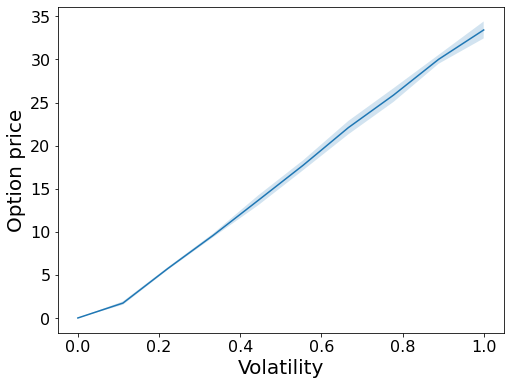

In [6]:
# Volatility price study
M = 10**3
n_instances = 10
mean_values, std_values = [], []

vols = np.linspace(0, 1, 10)

for vol in vols:

    manager = SimulationManager(MonteCarloStockManager, n_instances, M=M, vol=vol)

    mean, std = manager.calc_attribute(lambda man: man.calc_option_price()[1], run=False)

    mean_values.append(mean)
    std_values.append(std)

mean_values = np.array(mean_values)
std_values = np.array(std_values)

plt.plot(vols, mean_values)
plt.fill_between(vols, mean_values - std_values, mean_values + std_values, alpha=0.2)
plt.xlabel("Volatility")
plt.ylabel("Option price")
plt.show() 

## Part 2

In [3]:
# Fixed vs different seed

M=10**3
n_instances = 1000

manager = SimulationManager(MonteCarloStockManager, n_instances, M=M)
diff_seed_mean, diff_seed_std = manager.calc_attribute(lambda man: man.calc_hedge_parameter(0.01, fixed_seed=False)[0], run=False)
fixed_seed_mean, fixed_seed_std = manager.calc_attribute(lambda man: man.calc_hedge_parameter(0.01, fixed_seed=True)[0], run=False)

print(f"Binomial tree with N=1000: -0.3263\n")
print(f"Different seed delta: {diff_seed_mean} +- {diff_seed_std}")
print(f"Fixed seed delta: {fixed_seed_mean} +- {fixed_seed_std}")


Binomial tree with N=1000: -0.3263                         

Different seed delta: 0.1465559394630398 +- 36.04127357953111
Fixed seed delta: -0.32579678769032594 +- 0.012163911571475382


In [5]:
M=10**3
n_instances = 1000

manager = SimulationManager(MonteCarloStockManager, n_instances, M=M, option_type="digital")
bump_mean, bump_std = manager.calc_attribute(lambda man: man.calc_hedge_parameter(0.01, fixed_seed=False)[0], run=False)

manager = SimulationManager(MonteCarloStockManager, n_instances, M=M, option_type="digital")
path_mean, path_std = manager.calc_attribute(lambda man: man.calc_pathwise_digital_delta(0.1, 0.01), run=False)

manager = SimulationManager(MonteCarloStockManager, n_instances, M=M, option_type="digital")
like_mean, like_std = manager.calc_attribute(lambda man: man.calc_likelihood_digital_delta(), run=False)

print(f"Fixed seed bump delta: {bump_mean} +- {bump_std}")
print(f"Pathwise method delta: {path_mean} +- {path_std}")
print(f"Likelihood ratio delta: {like_mean} +- {like_std}")

Fixed seed bump delta: -0.09191621847782298 +- 2.031841264701333
Pathwise method delta: 0.019447328001358025 +- 0.0074583581401479835
Likelihood ratio delta: 0.018205771407801333 +- 0.0008679551562837193


## Part 3

In [9]:
# Compare asian monte carlo vs analytical
n_instances = 10
M=10**4
manager = SimulationManager(MonteCarloStockManager, n_instances, M=M, option_type="asian")
mean, std = manager.calc_attribute(lambda man: man.calc_option_price()[1], run=False)

asian_analytic = asian_option_value()
print(f"Monte carlo value: {mean} +- {std}")
print(f"Asian analytic {asian_analytic}")

Monte carlo value: 6.3048515150363 +- 0.05529872039905883
Asian analytic 6.322881823215251


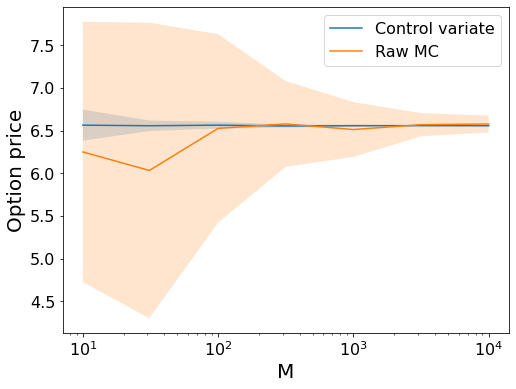

In [10]:
# Contol variate technique - Number of paths

n_instances = 10
Ms = np.logspace(1, 4, 7, dtype=int)
control_variate_means, control_variate_stds = [], []
MC_ari_means, MC_ari_stds = [], []
for M in Ms:
    print(f"Current M={M}", end='\r')
    control_variate_mean, control_variate_std, MC_ari_mean, MC_ari_std = obtain_mean_and_stds_control_variate(n_instances, M)

    control_variate_means.append(control_variate_mean)
    control_variate_stds.append(control_variate_std)
    MC_ari_means.append(MC_ari_mean)
    MC_ari_stds.append(MC_ari_std)

control_variate_means = np.array(control_variate_means)
control_variate_stds = np.array(control_variate_stds)
MC_ari_means = np.array(MC_ari_means)
MC_ari_stds = np.array(MC_ari_stds)

plt.plot(Ms, control_variate_means, label="Control variate")
plt.fill_between(Ms, control_variate_means - control_variate_stds, control_variate_means + control_variate_stds, alpha=0.2)
plt.plot(Ms, MC_ari_means, label="Raw MC")
plt.fill_between(Ms, MC_ari_means - MC_ari_stds, MC_ari_means + MC_ari_stds, alpha=0.2)

plt.legend()
plt.xlabel("M")
plt.ylabel("Option price")
plt.xscale("log")
plt.show() 


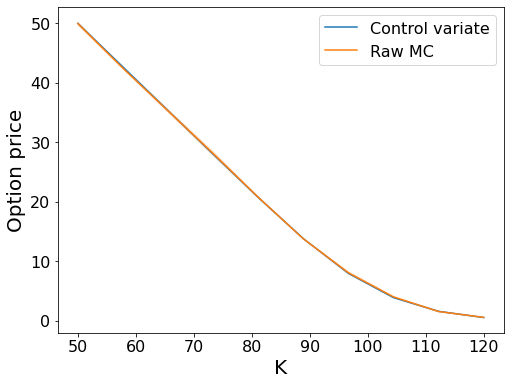

In [3]:
# Contol variate technique - Strike price

n_instances = 10
Ks = np.linspace(50, 120, 10)
M=10**3

control_variate_means, control_variate_stds = [], []
MC_ari_means, MC_ari_stds = [], []

for K in Ks:
    print(f"Current K={K}", end='\r')
    control_variate_mean, control_variate_std, MC_ari_mean, MC_ari_std = obtain_mean_and_stds_control_variate(n_instances, M, K=K)

    control_variate_means.append(control_variate_mean)
    control_variate_stds.append(control_variate_std)
    MC_ari_means.append(MC_ari_mean)
    MC_ari_stds.append(MC_ari_std)

control_variate_means = np.array(control_variate_means)
control_variate_stds = np.array(control_variate_stds)
MC_ari_means = np.array(MC_ari_means)
MC_ari_stds = np.array(MC_ari_stds)

plt.plot(Ks, control_variate_means, label="Control variate")
plt.fill_between(Ks, control_variate_means - control_variate_stds, control_variate_means + control_variate_stds, alpha=0.2)
plt.plot(Ks, MC_ari_means, label="Raw MC")
plt.fill_between(Ks, MC_ari_means - MC_ari_stds, MC_ari_means + MC_ari_stds, alpha=0.2)

plt.legend()
plt.xlabel("K")
plt.ylabel("Option price")
plt.show()

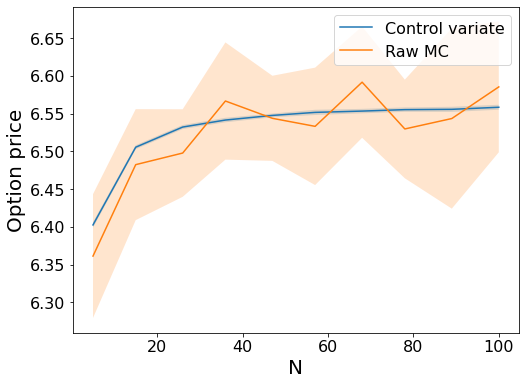

In [4]:
# Contol variate technique - sample points for averaging
n_instances = 10 
Ns = np.linspace(5, 100, 10,  dtype=int)
M = 10**4

control_variate_means, control_variate_stds = [], []
MC_ari_means, MC_ari_stds = [], []

for N in Ns:
    print(f"Current N={N}", end='\r')
    control_variate_mean, control_variate_std, MC_ari_mean, MC_ari_std = obtain_mean_and_stds_control_variate(n_instances, M, N=N)

    control_variate_means.append(control_variate_mean)
    control_variate_stds.append(control_variate_std)
    MC_ari_means.append(MC_ari_mean)
    MC_ari_stds.append(MC_ari_std)

control_variate_means = np.array(control_variate_means)
control_variate_stds = np.array(control_variate_stds)
MC_ari_means = np.array(MC_ari_means)
MC_ari_stds = np.array(MC_ari_stds)

plt.plot(Ns, control_variate_means, label="Control variate")
plt.fill_between(Ns, control_variate_means - control_variate_stds, control_variate_means + control_variate_stds, alpha=0.2)
plt.plot(Ns, MC_ari_means, label="Raw MC")
plt.fill_between(Ns, MC_ari_means - MC_ari_stds, MC_ari_means + MC_ari_stds, alpha=0.2)

plt.legend()
plt.xlabel("N")
plt.ylabel("Option price")
plt.show() 